[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guiwitz/DLImaging/blob/master/notebooks/12-TransferLearning_worms.ipynb)

# 12. Transfer learning

Most successful models have been trained on very large datasets, e.g  ImageNet, either by academic or private groups. If we are considering a convolutional network, this means that all filters in the network have been optimized to recognize specific features. If we want to use the same model architecture for a different problem (e.g. not one contained in the 1000 categories of ImageNet), we can't directly use such a pre-trained network. However we *can* keep most of the trained network which is super efficient at extracting information and adjust *only the last layer(s)* which do the classification.

In [52]:
from IPython.display import HTML, display, Image

# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/DLImaging/master/utils/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

In [53]:
Image(url='https://github.com/guiwitz/DLImaging/raw/master/illustrations/fine_tuning.jpg',width=800)

## Import a pre-trained network

We have already seen before that it is very simple to import pre-trained networks. We are going to use a ResNet model this time: 

In [3]:
import torchvision.models as models
import torch
from torch import nn

We wan check the content of the model:

In [4]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/gw18g940/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 19.1MB/s]


In [5]:
for name, module in model.named_children():
    print(f'name: {name} module: {module}')

name: conv1 module: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
name: bn1 module: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
name: relu module: ReLU(inplace=True)
name: maxpool module: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
name: layer1 module: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(i

We see that the classifier is only the very last layer ```fc``` which takes 512 inputs and outputs probabilities (not scaled) for 1000 categories (Imagenet). We want to now do two things: 
1. modifiy the last layer to output only 2 categories

In [6]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [7]:
model.fc = nn.Linear(512, 2, bias=True)

2. Make all the parameters non-trainable as we want to keep the trained filters as they are, **except** for the ```fc``` layer. To make parameters non-trainable we can simply use the ```requires_grad``` parameter. Let's check how many trainable parameters we have right now:

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
count_parameters(model)

11177538

Now we set all parameters as non-trainable:

In [10]:
for p in model.parameters():
    p.requires_grad = False

In [11]:
count_parameters(model)

0

And set only the very last ```fc``` layer to trainable again:

In [12]:
for p in model.fc.parameters():
    p.requires_grad = True

In [13]:
count_parameters(model)

1026

## Integration in Lightning module

Now we integrate these two elements in a more general Lighning module to simplify our life:

In [14]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np

In [15]:
class Myresnet(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super(Myresnet, self).__init__()
        
        
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(512, 2, bias=True)
        for p in model.parameters():
            p.requires_grad = False
        for p in model.fc.parameters():
            p.requires_grad = True
        
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        
        # define the sequence of operations in the network including e.g. activations
        x = self.model(x)
                
        return x
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output, y)
        
        self.log('Loss/train', loss, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Loss/Train", loss, self.current_epoch)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        accuracy = (torch.argmax(output,dim=1) == y).sum()/len(y)

        self.log('Accuracy/validation', accuracy, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Accuracy/Valid", accuracy, self.current_epoch)

        return accuracy
        
    def configure_optimizers(self):

        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)


## Dataset

As an example, we are going to train our network on a dataset from the [Broad Bioimage Benchmark Collection](https://bbbc.broadinstitute.org/) which provides microscopy datasets including various types of annotations. Here we use a dataset where C.elegans worms have been imaged in two conditions: in one they live happily and in the other they are dead. Here our goal is to fine-tune the network so that it can distinguish live from dead worms.

Let's first download the dataset:

In [16]:
import os, zipfile
if not datapath.joinpath('data/BBBC010_v2_images').is_dir():
    os.makedirs(datapath.joinpath('data/BBBC010_v2_images'))
    url = 'https://data.broadinstitute.org/bbbc/BBBC010/BBBC010_v2_images.zip'
    urllib.request.urlretrieve(url, datapath.joinpath('data/BBBC010_v2_images.zip'))
    with zipfile.ZipFile(datapath.joinpath('data/BBBC010_v2_images.zip'), 'r') as zip_ref:
        zip_ref.extractall(datapath.joinpath('data/BBBC010_v2_images'))
    os.remove(datapath.joinpath('data/BBBC010_v2_images.zip'))

The [dataset](https://bbbc.broadinstitute.org/BBBC010) is composed of a series of images acquired from a 384-well plate, i.e. a plate with 384 independent wells where worms can grow and be given different drugs. The plate is organised as a grid and we are told that columns 1-12 should be "alive-worms" for columns 13-24 should be "dead-worms". That column number is encoded in the image name ```xxxx_A01_w2_xxxx.tif``` where ```A``` is the row and ```01``` the columns. Images were acquired in two modes encoded as ```w1``` and ```w2``` and we use here ```w2```.

In [17]:
import skimage
import matplotlib.pyplot as plt

We use here scikit-image to import the images. Even though we could use PIL here, very often one has to use a domain-specific library to import data so we show it here as an example:

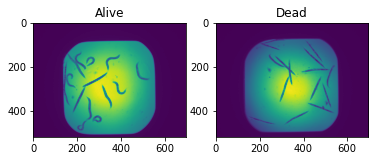

In [18]:
image1 = skimage.io.imread(datapath.joinpath('data/BBBC010_v2_images/1649_1109_0003_Amp5-1_B_20070424_A01_w2_15ADF48D-C09E-47DE-B763-5BC479534681.tif'))
image2 = skimage.io.imread(datapath.joinpath('data/BBBC010_v2_images/1649_1109_0003_Amp5-1_B_20070424_A15_w2_76386D69-006F-405F-8EA8-7D8A31989229.tif'))
fig, ax = plt.subplots(1,2)
ax[0].imshow(image1)
ax[0].set_title('Alive')
ax[1].imshow(image2)
ax[1].set_title('Dead');


Clearly the dead worms are elongated while the live ones are curly. The goal is for the network to learn these features for classification.

We have one problem to use these images in our pre-trained resnet:

In [19]:
model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

The first layer of the resnet takes a 3D image as input, normally an RGB image. We here only have 2D gray images:

In [20]:
image1.shape

(520, 696)

We can still use resnet, but will have to reshape our images so that they fit in the network. We can do that before or after transforming the image into a tensor. For example we can use scikit-image:

In [21]:
image_rgb = skimage.color.gray2rgb(image1)
image_rgb.shape

(520, 696, 3)

or directly PyTorch:

In [22]:
import torch

x = torch.tensor(image1.astype(np.float32))
x = x.unsqueeze_(0).repeat(3, 1, 1)
x.shape

torch.Size([3, 520, 696])

We see that the "third" dimension is in a different position, but this is taken care of automatically by using ```transform.ToTensor```:

In [23]:
image1.shape

(520, 696)

In [24]:
transforms.ToTensor()(image1.astype(np.float32)).shape

torch.Size([1, 520, 696])

Here we will first do gray to RGB transformation in numpy and then use a ```transform``` for additional changes. As we don't care about the area outside the imaged one (square) we will here simply crop a central region in the image. As we don't have many images, we will also use data augmentation to improve learning. We use here horizontal and vertical flip as well as random rotation **only** for training of course:

In [25]:
mytransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90)
]
)

mytransform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(256)
]
)

### Parsing the files

As mentioned above, we have to create the labels for classification by extracting information from the image titles. We have to recover the ```xxxx_A01_xxxx``` information. First let's find the content of the folder and keep only files of the second channel ```w2``` using the ```glob``` method of a ```Path```:

In [26]:
import os
from pathlib import Path

In [27]:
worm_path = datapath.joinpath('data/BBBC010_v2_images/')

In [28]:
files = list(worm_path.glob('*w2*'))
files[0:3]

[PosixPath('../data/BBBC010_v2_images/1649_1109_0003_Amp5-1_B_20070424_C23_w2_029A07BB-0E92-42C2-A678-E013A24A4651.tif'),
 PosixPath('../data/BBBC010_v2_images/1649_1109_0003_Amp5-1_B_20070424_D01_w2_296FE96D-4B74-4DA0-92A3-D82AA7794078.tif'),
 PosixPath('../data/BBBC010_v2_images/1649_1109_0003_Amp5-1_B_20070424_A18_w2_096A8F91-79FF-484F-A55D-6154366E1EAF.tif')]

Now we use a regular expression to extract the column number. We are lookg for something with the structure ```xxx_[a capital letter][a number]_xxxx``` and therefore use the expression ```'.*?\_[A-Z](\d+)\_.*'```

In [29]:
import re
column = np.array([int(re.findall('.*?\_[A-Z](\d+)\_.*', x.name)[0]) for x in files])

Then we create a label array. Labels for columns 1-12 are 0 and mean alive, while labels for columns>12 are 1 and mean dead worms:

In [30]:
labels = np.zeros_like(column)
labels[column>12] = 1
label_dict = {0: 'alive', 1: 'dead'}

Now we can integrate these steps in a ```Dataset```. We import the images directly in the object and therefore simply pass a folder containing the data as parameter.

In [31]:
class Worms(Dataset):
    def __init__(self, data_path, transform=None):
        super(Worms, self).__init__()
        
        self.data_path = Path(data_path)
        self.data_list = list(data_path.glob('*w2*'))
        
        column = np.array([int(re.findall('.*?\_[A-Z](\d+)\_.*', x.name)[0]) for x in self.data_list])
        labels = np.zeros_like(column)
        labels[column>12] = 1
        self.labels = labels
        self.label_dict = {0: 'alive', 1: 'dead'}
    
        self.transform = transform
        
    def __getitem__(self, index):
        
        x = skimage.io.imread(self.data_list[index])
        x = skimage.color.gray2rgb(x).astype(np.float32)
        if self.transform is not None:
            x = self.transform(x)
        y = torch.tensor(self.labels[index], dtype=torch.int64)
        
        return x, y

    def __len__(self):

        return len(self.data_list)

Let's check that the output is as expected:

In [32]:
test = Worms(worm_path, mytransform)
im, lab = test[0]

In [33]:
im.shape

torch.Size([3, 256, 256])

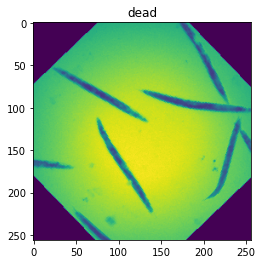

In [34]:
fig, ax = plt.subplots()
ax.imshow(im[0])
ax.set_title(test.label_dict[lab.item()]);

We now create two datasets containing the same images but with a different ```transform```, one with augmentation for the training step and one without for the validation step. 

In [35]:
worm_train = Worms(worm_path, mytransform)
worm_valid = Worms(worm_path, mytransform_valid)

In [36]:
x, y = worm_train[10]
x2, y2 = worm_valid[10]

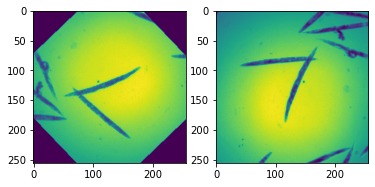

In [37]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(x[0,:,:])
ax[1].imshow(x2[0,:,:]);

Of course at the moment the training and validation ```Dataset``` contain the same images. We want to split them now into two *disjoint* sets. For that we scramble the list of indices, split it, and pass the two disjoint sets via the ```sampler``` parameter.

In [38]:
train_size = int(0.8 * len(worm_train))
valid_size = len(worm_train)-train_size

random_indices = np.random.permutation(np.arange(len(worm_train)))

In [39]:
batch_size = 10

rng = np.random.default_rng()
indices = rng.choice(len(worm_train), size=len(worm_train), replace=False)

train_loader = DataLoader(worm_train,
                          sampler=random_indices[0:train_size], batch_size=batch_size)
validation_loader = DataLoader(worm_valid,
                          sampler=random_indices[train_size::], batch_size=batch_size)

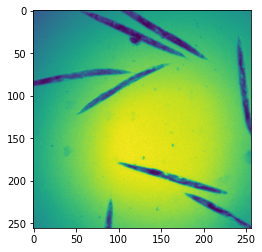

In [40]:
x, y = next(iter(validation_loader))
plt.imshow(x[0,0]);

## Training

Finally we can train the network, or rather the *last layer* of the network. We see in the information output from Lightning that we have 11M parameters but only 1K *trainable* ones which is what we expected.

In [41]:
#del myresnet
myresnet = Myresnet()

In [42]:
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="worm")

In [43]:
trainer = pl.Trainer(max_epochs=10, logger=logger)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [44]:
trainer.fit(myresnet, train_dataloaders=train_loader, val_dataloaders=validation_loader)


  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 9: 100%|██████████| 10/10 [00:23<00:00,  2.35s/it, loss=0.26, v_num=1, Loss/train_step=0.303, Accuracy/validation=1.000, Loss/train_epoch=0.244] 


In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb_logs

## Testing the result

We see that we have achieved a good accuracy in just a few epochs. We check visually on a validation batch the result of our network.

In [45]:
test_batch, test_label = next(iter(validation_loader))

pred_label = myresnet(test_batch)
pred_label = pred_label.argmax(dim=1)

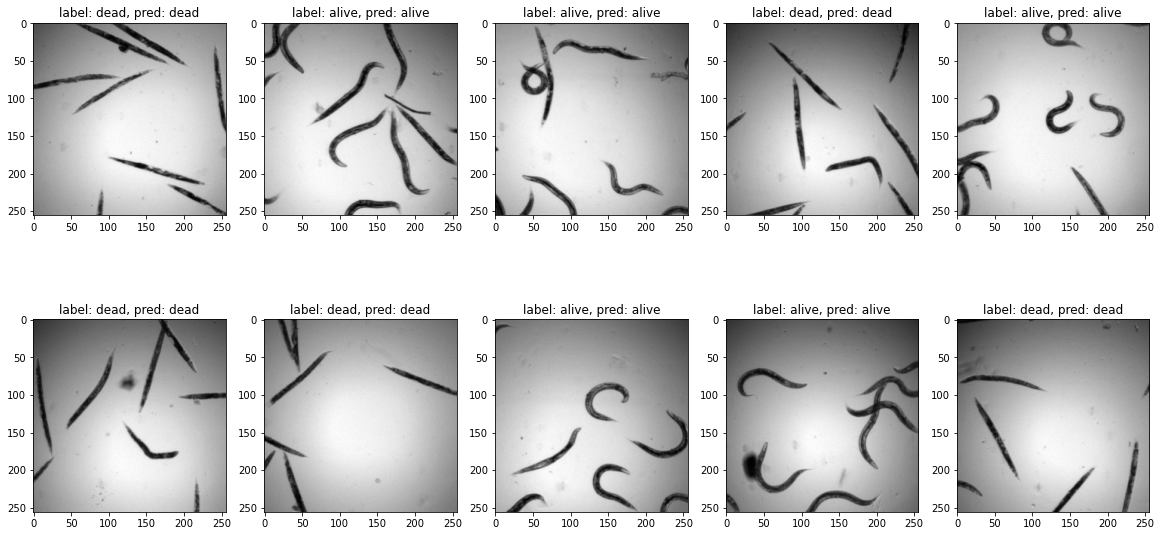

In [46]:
fig = plt.figure(figsize=(20,10))
spec = fig.add_gridspec(ncols=5, nrows=2)

count=0
for row in range(2):
    for col in range(5):
        ax = fig.add_subplot(spec[row, col])
        ax.imshow(test_batch[count,0,:,:],cmap='gray')
        ax.set_title(f'label: {label_dict[test_label[count].item()]}, pred: {label_dict[pred_label[count].item()]}')
        count+=1

## Fine tuning

The above problem is relatively simples as we have two classes. But in many cases, it might be necessary to go one step further and to *fine-tune* the entire network, i.e. unfreeze the layers that we set to ```requires_grad = False```. When we do this, we want to use a smaller learning rate as we don't want to completely disturb the network which has been carefully trained on a very large dataset.

Generally, great care has to be taked when trying to fine-tune a system, and one has many options: one could use different learing rates for different layers, unfreeze only part of the convolution layers etc. but this goes beyond the frame of this course.

For the moment we just unfreeze the network and lower the learning rate by a factor of 10. Training the entire network is also interesting here because this will allow us to explore more in detail what features are important for the image classification.

In [47]:
del myresnet
myresnet = Myresnet(learning_rate=1e-4)

In [48]:
for p in myresnet.parameters():
    p.requires_grad = True

In [49]:
logger = TensorBoardLogger("tb_logs", name="worm_finetune")
trainer = pl.Trainer(max_epochs=10, logger=logger)
trainer.fit(myresnet, train_dataloaders=train_loader, val_dataloaders=validation_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
Missing logger folder: tb_logs/worm_finetune

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Epoch 2:  30%|███       | 3/10 [00:37<01:26, 12.34s/it, loss=0.299, v_num=0, Loss/train_step=0.0186, Accuracy/validation=1.000, Loss/train_epoch=0.172]

/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
%tensorboard --logdir tb_logs

We see that here again we obtain a very good result with a validation accuracy that increases and starts to pleateau around 1. If we would run many more epochs, we would probably see the validation accuracy start to dip because of over-training and disruption of the finely adjusted network that we inherited.

## Problems

Our fine-tuning worked remarkably well. We just verify here that everything worked normally by creating conditions *designed* to make learning fail. For example we can feed a tiny amount of data, with a single example of one of the two categories:

In [50]:
worm_train = Worms(worm_path, mytransform_valid)

# dead indices: [0,2,4,7,8,10]
# mixed indices: [0,2,4,1,3,5]
# single live: [0,1,2,4,7,8]
train_loader = DataLoader(worm_train,
                          sampler=[0,1,2,4,7,8], batch_size=2)
validation_loader = DataLoader(worm_valid,
                          sampler=np.arange(20,40), batch_size=batch_size)

badresnet = Myresnet(learning_rate=1e-4)

for p in badresnet.parameters():
    p.requires_grad = True
    
logger = TensorBoardLogger("tb_logs", name="worm_finetune")
trainer = pl.Trainer(max_epochs=20, logger=logger)
trainer.fit(badresnet, train_dataloaders=train_loader, val_dataloaders=validation_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 7:   0%|          | 0/5 [00:00<?, ?it/s, loss=0.475, v_num=1, Loss/train_step=0.159, Accuracy/validation=0.750, Loss/train_epoch=0.122]          

We can see that the validation first improved before degrading again, the network trying to optimize globally and having many more example of one category just classifies everything into that category:

In [54]:
Image(url='https://github.com/guiwitz/DLImaging/raw/master/illustrations/dead_alive_imbalance.png')

Epoch 2:  30%|███       | 3/10 [07:21<17:09, 147.02s/it, loss=0.299, v_num=0, Loss/train_step=0.0186, Accuracy/validation=1.000, Loss/train_epoch=0.172]


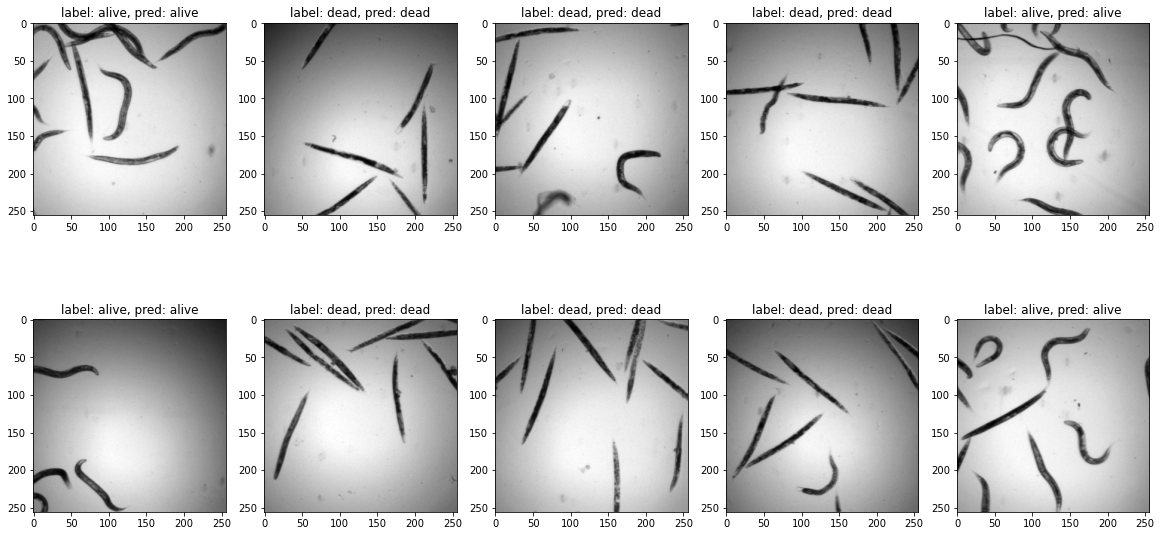

In [55]:
test_batch, test_label = next(iter(validation_loader))

pred_label = myresnet(test_batch)
pred_label = pred_label.argmax(dim=1)

fig = plt.figure(figsize=(20,10))
spec = fig.add_gridspec(ncols=5, nrows=2)

count=0
for row in range(2):
    for col in range(5):
        ax = fig.add_subplot(spec[row, col])
        ax.imshow(test_batch[count,0,:,:],cmap='gray')
        ax.set_title(f'label: {label_dict[test_label[count].item()]}, pred: {label_dict[pred_label[count].item()]}')
        count+=1

## Interpretability

Finally we can again play the game of interpretability to understand what parts of the image the network uses for classification. Normally, like with the drawings, we should see the worms themselves as important elements.

In [56]:
from captum.attr import Saliency
from captum.attr import visualization as viz

We need to unfreeze all parameters (if not already done):

In [57]:
for p in myresnet.parameters():
    p.requires_grad = True

Then we calculate the ```saliency``` map for a series of images. We should not forget to add the input images to the gradient calculation using ```requires_grad```. We also use here a plotting function comming directly from the Captum package:

In [58]:
test_batch, test_label = next(iter(validation_loader))

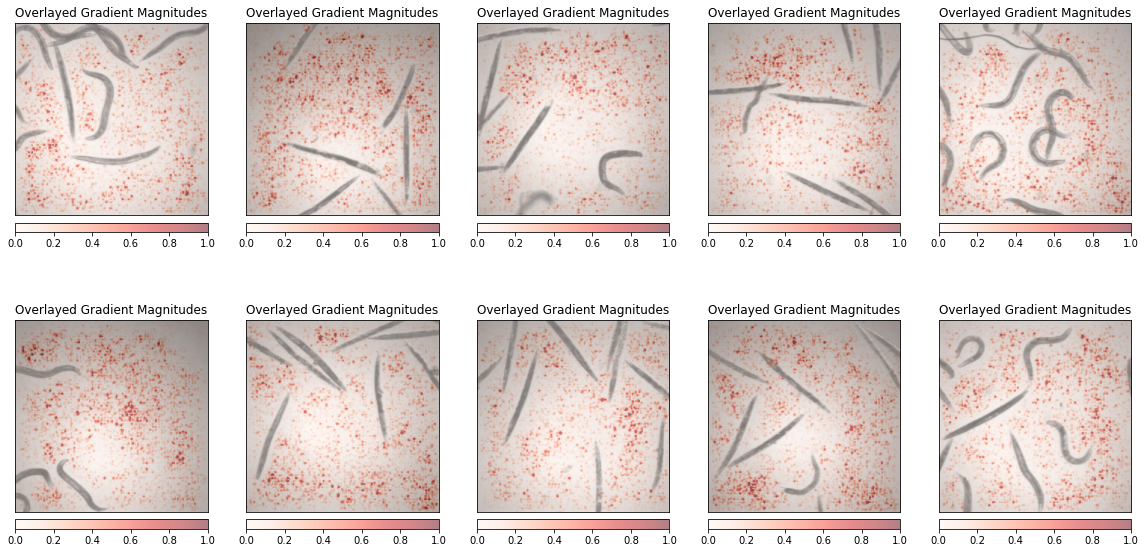

In [59]:
fig = plt.figure(figsize=(20,10))
spec = fig.add_gridspec(ncols=5, nrows=2)

ind=0
for row in range(2):
    for col in range(5):
        
        ax = fig.add_subplot(spec[row, col])
        
        myinput = test_batch[ind].unsqueeze(0)
        myinput.requires_grad = True

        saliency = Saliency(myresnet)
        grads = saliency.attribute(myinput, target=test_label[ind].item())
        grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
        original_image = myinput.detach().numpy()[0]
        original_image = np.rollaxis(original_image,0,3)
        ind+=1
        
        _ = viz.visualize_image_attr(grads, original_image, cmap='Reds', method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes", plt_fig_axis = (fig, ax),use_pyplot=False)